## Import Modules

In [1]:
import os
import pickle
import string
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '..\Semester_4_project\dataset'
WORKING_DIR = '..\Semester_4_project'

## Extract Image Features

In [3]:
#Load VGG16 model
model = VGG16()
#restructure of model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# Summarize
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR,'Images')
for img_name in  tqdm(os.listdir(directory)):
    # load the image from file
    img_path =  directory + '/' + img_name
    image = load_img(img_path , target_size=(224,224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0) 
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature


  0%|          | 0/8031 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR,'features.pk1'),'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pk1'), 'rb') as f:
    features = pickle.load(f)

## Load Caption Data

In [5]:
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    try:
        image_id, caption = tokens[0], tokens[1:]
        # remove extension from image ID
        image_id = image_id.split('.')[0]
        # convert caption list to string
        caption = " ".join(caption)
        # create list if needed
    except:
        caption = np.nan
        
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping)

8091

## Preprocess Text Data

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]','')
            # delete additional spaces
            caption = caption.replace('.',' ')
            # add start and end tags to the caption
            caption = caption.replace('\s+','')
            caption = caption.replace('\d+','')

            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption 

In [9]:
# before preprocess of text
mapping['97577988_65e2eae14a']

['A man mountain climbing up an icy mountain .',
 'An climber is ascending an ice covered rock face .',
 'A person in orange climbs a sheer cliff face covered in snow and ice .',
 'Person in a yellow jacket is climbing up snow covered rocks .',
 'There is a climber scaling a snowy mountainside .']

In [10]:
# preprocess the text
clean(mapping)

In [11]:
# after preprocess of text
mapping['97577988_65e2eae14a']

['startseq man mountain climbing up an icy mountain endseq',
 'startseq an climber is ascending an ice covered rock face endseq',
 'startseq person in orange climbs sheer cliff face covered in snow and ice endseq',
 'startseq person in yellow jacket is climbing up snow covered rocks endseq',
 'startseq there is climber scaling snowy mountainside endseq']

In [12]:
img_filename = []

for f in os.listdir('..\Semester_4_project\dataset\Images'):
    img_filename.append((f.split('.'))[0])

In [13]:
len(img_filename)

8031

In [14]:
#Find intersection set
intersection = set(img_filename) & set(mapping.keys())

In [15]:
len(intersection)

8031

In [16]:
#Filter mapping from intersection
from funcy import project
mapping = project(mapping,intersection)

In [17]:
len(mapping)

8031

In [18]:
#collect all captions in mapping into list  all_captions
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40155

In [20]:
all_captions[:10]

['startseq black and white dog jumps in pool filled with tennis balls endseq',
 'startseq black and white dog swimming in the pool endseq',
 'startseq black and white dog swims and plays with tennis balls in the pool endseq',
 'startseq black and white dog swims for tennis balls endseq',
 'startseq there is black and white dog in sparking blue pool endseq',
 'startseq warmly dressed woman in black kneels with small tan dog near crowd of onlookers endseq',
 'startseq woman in winter clothing kneels next to small brown and white dog in the snow endseq',
 'startseq woman kneeling in the snow attaching harness on small tan dog endseq',
 'startseq woman puts harness on her small brown dog while in the snow endseq',
 'startseq the woman is holding the harness that the brown and white dog is wearing endseq']

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
vocab_size

8446

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split())for caption in all_captions)
max_length

34

## Train Test Split

In [24]:
image_ids =  list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [25]:
# startseq  girl is going into wooden building endseq 
#         x                y
#startseq                  girl
#startseq  girl            going
#startseq  girl going       into
#...................
# startseq  girl is going into wooden building endseq 



In [26]:
#create data generator to get data inbatch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #loop over images
    X1, X2, y = list(),list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the  sequence into x, y pairs
                for i in range(1,len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i],seq[i]
                    #pad input sequence
                    in_seq = pad_sequences([in_seq],maxlen = max_length)[0]
                    #encode output sequence
                    out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]
                    
                    #store the sequence
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1,X2],y
                X1, X2, y = list(),list(), list()
                n = 0

## Model Creation

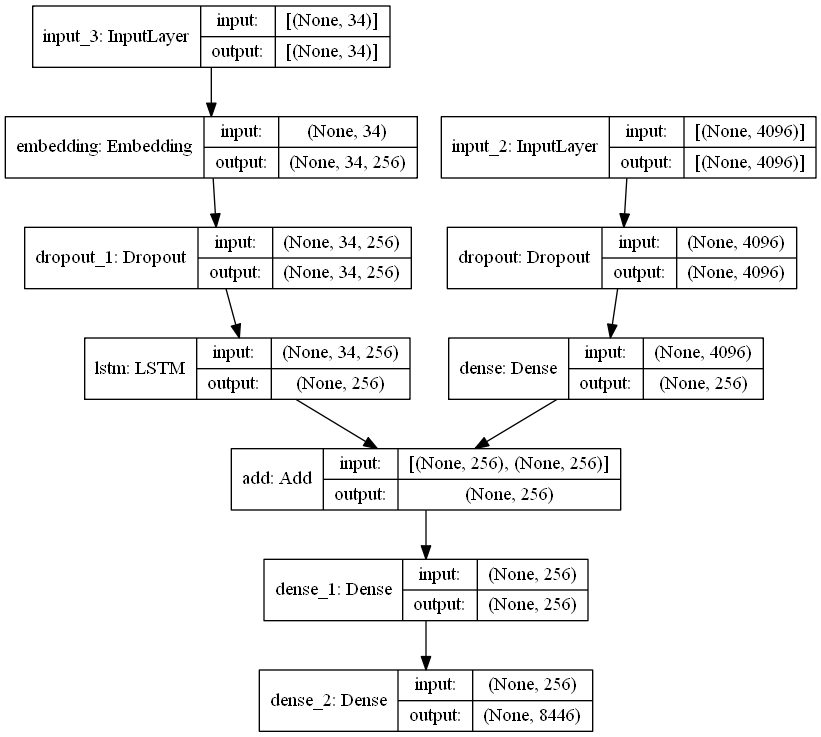

In [27]:
inputs1 = Input(shape = (4096,) )
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation ='relu')(fe1)
#sequence feature layers
inputs2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero =True )(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2 ,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1 ,inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

#plot the model
plot_model(model,show_shapes = True)

## Train The Model

In [28]:
# Train The Model
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    #create data generator
    generator = data_generator(train,mapping, features, tokenizer, max_length, vocab_size ,batch_size)
    
    #compile model
    model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    #fit model
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


225/225 [==============================] - 856s 4s/step - loss: 7.3774e-04 - accuracy: 0.1369


In [29]:
# save the model 
model.save(WORKING_DIR + '/best_model.h5')

c:\Users\ankit\anaconda3\envs\tenserflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Generate Captions for the Image

In [30]:
def idx_to_word(integer, tokenizer):
    for word ,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
#Generate caption for a image

def predict_caption(model, image,tokenizer,max_length):
    in_text = 'startseq'
    #iterate over the max length of sequence 
    for i in range(max_length):
        #encode input sequence 
        sequence  = tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence = pad_sequences([sequence],max_length)
        #predict next word 
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        #convert index into word
        word = idx_to_word(yhat, tokenizer)
        #stop if he word not found
        if word is None:
            break
        #if append word as input for generating next word
        in_text += " "+word
        #stop if we reach end tag
        if word == 'endseq':
            break
    return in_text



In [32]:
#validate with test case data
actual, predicted = list(),list()

for key in tqdm(test):
    #get actual caption 
    captions = mapping[key]
    #predict the caption for  image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_caption = [caption.split() for caption in captions]
    #append to the list
    actual.append(actual_caption)
    predicted.append(y_pred)


  0%|          | 0/804 [00:00<?, ?it/s]

In [33]:
from nltk.translate.bleu_score import corpus_bleu


#calculate BLEU scorer
print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0,0,0)))



BLEU-1: 0.000000
BLEU-2: 0.000000


## Visiualize the Results

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
# load the image 

def generate_caption(image_name):
    #image_name = " "
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images",image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('--------------------Actual--------------------')
    for caption in captions:
        print(caption)
        
    y_pred = predict_caption(model, features[image_id],tokenizer,max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Actual--------------------
startseq man mountain climbing up an icy mountain endseq
startseq an climber is ascending an ice covered rock face endseq
startseq person in orange climbs sheer cliff face covered in snow and ice endseq
startseq person in yellow jacket is climbing up snow covered rocks endseq
startseq there is climber scaling snowy mountainside endseq
--------------------Predicted--------------------
startseq person person snowy snowy snowy snowy endseq


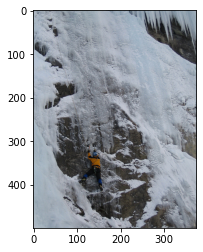

In [35]:
generate_caption("97577988_65e2eae14a.jpg")

--------------------Actual--------------------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
--------------------Predicted--------------------
startseq dog dog dog dog dog dog endseq
--------------------Actual--------------------
startseq child and woman are at waters edge in big city endseq
startseq large lake with lone duck swimming in it with several people around the edge of it endseq
startseq little boy at lake watching duck endseq
startseq young boy waves his hand at the duck in the water surrounded by green park endseq
startseq "two people are at the edge of lake facing the water and the city skyline endseq
--------------------Predicted--------------------
startseq man peo

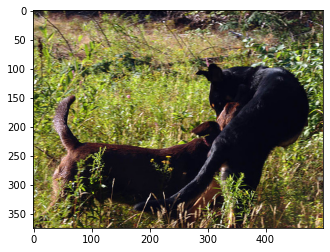

In [36]:
img_list = ['1009434119_febe49276a.jpg', '1022454332_6af2c1449a.jpg', '104136873_5b5d41be75.jpg', '105342180_4d4a40b47f.jpg', '1227655020_b11a1bb112.jpg']

for i in img_list:
    generate_caption(i)